tgb - 3/4/2020 - Preparing figures for our March 2020 PRL submission. Draws heavily from notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/022_Figure_Conserving_NN.ipynb]

# Initialization

## Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


## Plot properties

In [2]:
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Vertical profiles of squared error

In [4]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

## Comparison between linear, UCnet, LCnet and ACnet

### From model

In [18]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

In [19]:
NNarray = ['JNNL','JNNL0.01','JNNC','MLRL0']
NNname = ['$\mathrm{UCnet}$','$\mathrm{LCnet_{0.01}}$','$\mathrm{ACnet}$','$\mathrm{Linear}$']
DATASET = ['train','valid','test']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc'

In [9]:
MSEv = {}
MSEt = {}
RESt = {}

for datas in DATASET:
    MSEv[datas] = {}
    MSEt[datas] = {}
    RESt[datas] = {}
    
for NNs in NNarray:
    print('NNs = ',NNs)
    MSEv[datas][NNs] = {}
    MSEt[datas][NNs] = {}
    RESt[datas][NNs] = {}
    
    for datas in DATASET:
        print('dataset=',datas)
        # 1) Load model
        print('Loading model')
        path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
        NN = load_model(path,custom_objects=dict_lay)

        # 2) Define model diagnostics object
        print('Building model diagnostics object')
        md = ModelDiagnostics(NN,config_fn,data_fn)

        # 3) Calculate statistics and save in pickle file
        print('Calculating mean-squared error')
        path = TRAINDIR+'HDF5_DATA/'+NNs+'md_'+datas+'.pkl'
        md.stats = pickle.load(open(path,'rb'))
        MSEv[datas][NNs] = md.mse_W2m4().mean(axis=(0,1))
        MSEt[datas][NNs] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))

        # 4) Calculate budget residuals and save in pickle file
        print('Calculating residual')
        path = TRAINDIR+'HDF5_DATA/'+NNs+'res_'+datas+'.pkl'
        md.res = pickle.load(open(path,'rb'))
        tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
        RESt[datas][NNs] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

NNs =  JNNL
dataset= train
Loading model
Building model diagnostics object


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating mean-squared error
Calculating residual
dataset= valid
Loading model
Building model diagnostics object
Calculating mean-squared error


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating residual
dataset= test
Loading model
Building model diagnostics object


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating mean-squared error
Calculating residual
NNs =  JNNL0.01
dataset= train
Loading model
Building model diagnostics object
Calculating mean-squared error


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating residual
dataset= valid
Loading model
Building model diagnostics object


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating mean-squared error
Calculating residual
dataset= test
Loading model
Building model diagnostics object
Calculating mean-squared error

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)



Calculating residual
NNs =  JNNC
dataset= train
Loading model
Building model diagnostics object
Calculating mean-squared error


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating residual
dataset= valid
Loading model
Building model diagnostics object


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating mean-squared error
Calculating residual
dataset= test
Loading model
Building model diagnostics object
Calculating mean-squared error


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
W0307 02:16:53.148430 22382535735104 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Calculating residual
NNs =  MLRL0
dataset= train
Loading model
Building model diagnostics object
Calculating mean-squared error


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating residual
dataset= valid
Loading model
Building model diagnostics object


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating mean-squared error
Calculating residual
dataset= test
Loading model
Building model diagnostics object


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Calculating mean-squared error
Calculating residual


In [16]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(e\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(f\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

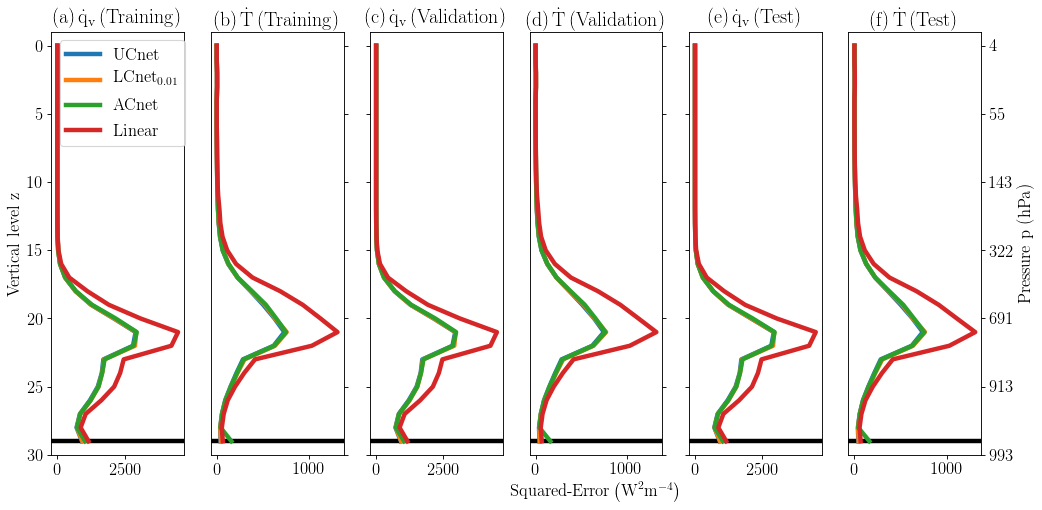

In [24]:
f = plt.figure(num=None, figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label=NNname[i])
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==5 or ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==4:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==6:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2 or ifig==4: labels[ilab]=''
        elif ifig==6: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)
    
# Save figure
# plt.savefig('Fig4.pdf',format='pdf')

In [26]:
# Save reduced data to make figure
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [27]:
hf = open(pathPKL+'2020_03_06_comparison.pkl','wb')
S = {"MSEv":MSEv,"MSEt":MSEt,"RESt":RESt,"lev":coor.lev}
pickle.dump(S,hf)
hf.close()

### From reduced data

In [20]:
# Save reduced data to make figure
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [21]:
hf = open(pathPKL+'2020_03_06_comparison.pkl','rb')
S = pickle.load(hf)
hf.close()
MSEv = S['MSEv']
lev = S['lev']

In [22]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Training}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(e\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(f\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

In [23]:
NNarray = ['JNNL','JNNL0.01','JNNC','MLRL0']
NNname = ['$\mathrm{UCnet}$','$\mathrm{LCnet_{0.01}}$','$\mathrm{ACnet}$','$\mathrm{Linear}$']
DATASET = ['train','valid','test']
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc'

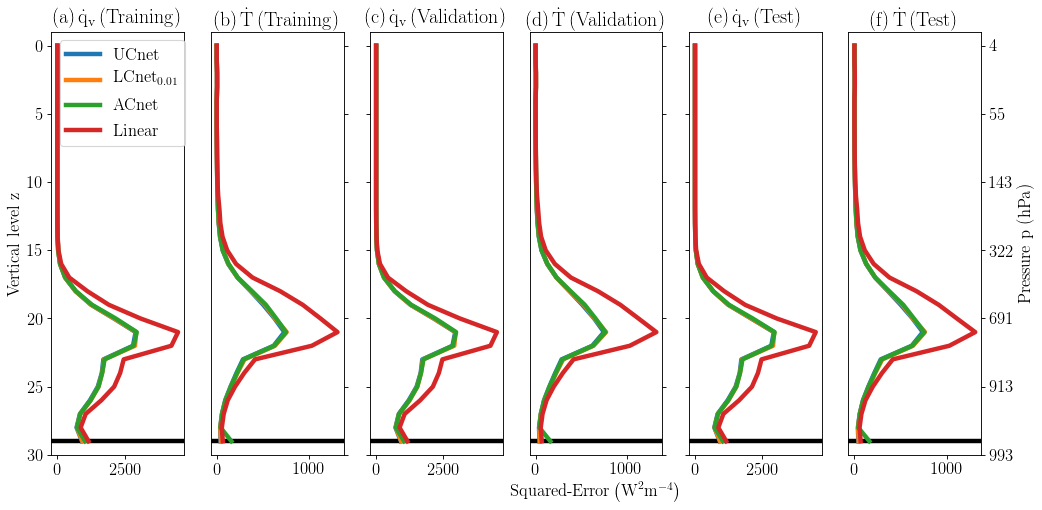

In [25]:
f = plt.figure(num=None, figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label=NNname[i])
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==5 or ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,6,ifig)

    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==4:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==6:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2 or ifig==4: labels[ilab]=''
        elif ifig==6: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig('Fig_prof_comparison.pdf',format='pdf')

## Sensitivity to Residual Level 

See notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/020_Sensitivity_Residual_level_Conservation.ipynb]

### From model

In [26]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice': MassConsLayer_choice,\
            'EntConsLayer_choice': EntConsLayer_choice}

NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']; 
REs = 'mdres'; 
FOR = 'hdf5'
DATASET = ['valid','test']

In [26]:
MSEv = {}
MSEt = {}
RESt = {}

for j,datas in enumerate(DATASET):
    MSEv[datas] = {}
    MSEt[datas] = {}
    RESt[datas] = {}
    #print('j=',j,'and datas=',datas)
    data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_'+datas+'.nc'
    for i,NNs in enumerate(NNarray):
        print('i =',i,' so case #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        #print('Loading model') # 1) Load model
        NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+'.'+FOR,custom_objects=dict_lay)
        #print('Loading statistics') # 2) Define model diagnostics object
        print(NNs)
        md = ModelDiagnostics(NN,config_fn,data_fn)
        # 3) Calculate statistics and save in pickle file
        path_end = 'md'+str(datas)+'.pkl'
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        MSEv[datas][NNs] = md.mse_W2m4().mean(axis=(0,1))
        MSEt[datas][NNs] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))
        # 4) Load residuals
        path_end = 'mdres'+str(datas)+'.pkl'
        md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
        tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
        RESt[datas][NNs] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

i = 0  so case # 1
Cm0_e0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 1  so case # 2
Cm14_e14


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 2  so case # 3
Cm29_e29


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 3  so case # 4
Cm0_e29


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 4  so case # 5
Cm29_e0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 0  so case # 6
Cm0_e0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 1  so case # 7
Cm14_e14


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 2  so case # 8
Cm29_e29


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 3  so case # 9
Cm0_e29


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


i = 4  so case # 10
Cm29_e0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [7]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

In [8]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

ValueError: num must be 1 <= num <= 4, not 5

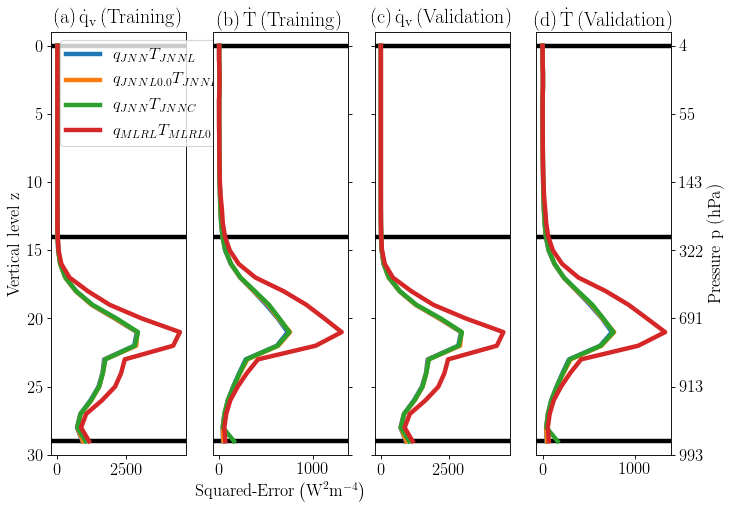

In [25]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)
    
    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        pU = nn.find('_')
        pm = nn.find('m')
        pe = nn.find('e')

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label='$q_{'+nn[pm+1:pU]+'}T_{'+nn[pe+1:]+'}$')
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)
    
# Save figure
# plt.savefig('Fig4.pdf',format='pdf')

In [29]:
datas = 'valid'
for i,nn in enumerate(NNarray):
    print(datas,i,nn,'MSE',MSEt[datas][NNs])
    print(datas,i,nn,'RES',RESt[datas][NNs])
    
datas = 'test'
for i,nn in enumerate(NNarray):
    print(datas,i,nn,'MSE',MSEt[datas][NNs])
    print(datas,i,nn,'RES',RESt[datas][NNs])

valid 0 Cm0_e0 MSE (157.3515652764862, 979.1322196215859)
valid 0 Cm0_e0 RES (7.617920535100867e-10, 1.2654637146166686e-09)
valid 1 Cm14_e14 MSE (157.3515652764862, 979.1322196215859)
valid 1 Cm14_e14 RES (7.617920535100867e-10, 1.2654637146166686e-09)
valid 2 Cm29_e29 MSE (157.3515652764862, 979.1322196215859)
valid 2 Cm29_e29 RES (7.617920535100867e-10, 1.2654637146166686e-09)
valid 3 Cm0_e29 MSE (157.3515652764862, 979.1322196215859)
valid 3 Cm0_e29 RES (7.617920535100867e-10, 1.2654637146166686e-09)
valid 4 Cm29_e0 MSE (157.3515652764862, 979.1322196215859)
valid 4 Cm29_e0 RES (7.617920535100867e-10, 1.2654637146166686e-09)
test 0 Cm0_e0 MSE (155.1995437196781, 970.8405595969147)
test 0 Cm0_e0 RES (7.685692005833281e-10, 1.2997373868778616e-09)
test 1 Cm14_e14 MSE (155.1995437196781, 970.8405595969147)
test 1 Cm14_e14 RES (7.685692005833281e-10, 1.2997373868778616e-09)
test 2 Cm29_e29 MSE (155.1995437196781, 970.8405595969147)
test 2 Cm29_e29 RES (7.685692005833281e-10, 1.29973738

In [30]:
# Save reduced data to make figure
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [31]:
hf = open(pathPKL+'2020_03_06_sens2reslev.pkl','wb')
S = {"MSEv":MSEv,"MSEt":MSEt,"RESt":RESt,"lev":coor.lev}
pickle.dump(S,hf)
hf.close()

### From reduced data

In [27]:
# Save reduced data to make figure
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [28]:
hf = open(pathPKL+'2020_03_06_sens2reslev.pkl','rb')
S = pickle.load(hf)
hf.close()

MSEv = S['MSEv']
lev = S['lev']

In [29]:
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values

In [30]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice': MassConsLayer_choice,\
            'EntConsLayer_choice': EntConsLayer_choice}

NNarray = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']; 
REs = 'mdres'; 
FOR = 'hdf5'
DATASET = ['valid','test']

In [31]:
TITLE = [r'$\mathrm{\left(a\right)\dot{q}_{v}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(b\right)\dot{T}\left(\mathrm{Validation}\right)}$',
         r'$\mathrm{\left(c\right)\dot{q}_{v}\left(\mathrm{Test}\right)}$',
         r'$\mathrm{\left(d\right)\dot{T}\left(\mathrm{Test}\right)}$']
YMIN = -1
YMAX = 30

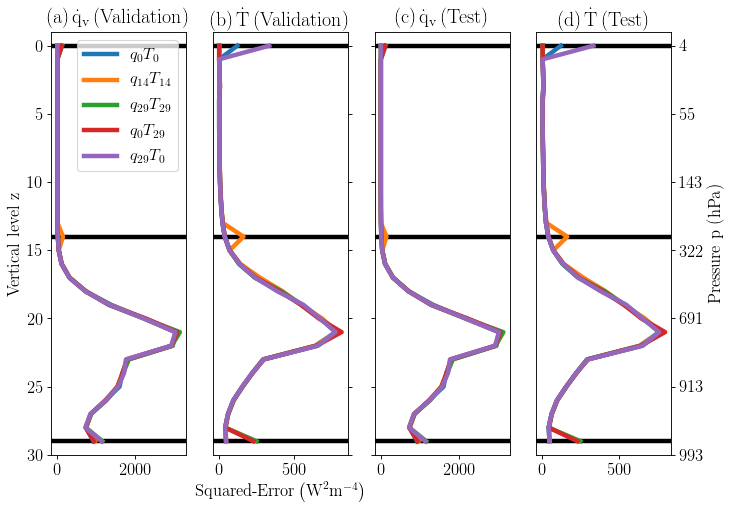

In [33]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)
    
    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        pU = nn.find('_')
        pm = nn.find('m')
        pe = nn.find('e')

        ax.plot(MSEv[datas][nn][:30],np.linspace(0,29,num=30),label='$q_{'+nn[pm+1:pU]+'}T_{'+nn[pe+1:]+'}$')
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=0,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    plt.axhline(y=29,color='k',linewidth=lw,zorder=0)
    
    for i,nn in enumerate(NNarray):
        ax.plot(MSEv[datas][nn][90:120],np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%lev[IND].values)
    ax.set_yticklabels(labels)
    
#Save figure
plt.savefig('Fig_prof_reslev.pdf',format='pdf')

## Targetting residual bias by using weighted loss

See notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/036_ACnet_Targetted_Loss.ipynb]

In [34]:
S = {}

hf = open(pathPKL+'2020_03_04_validgen036.pkl','rb')
S['valid'] = pickle.load(hf)
hf.close()

hf = open(pathPKL+'2020_03_04_testgen036.pkl','rb')
S['test'] = pickle.load(hf)
hf.close()

In [35]:
mult_array = np.array([1,2,5,10,20])

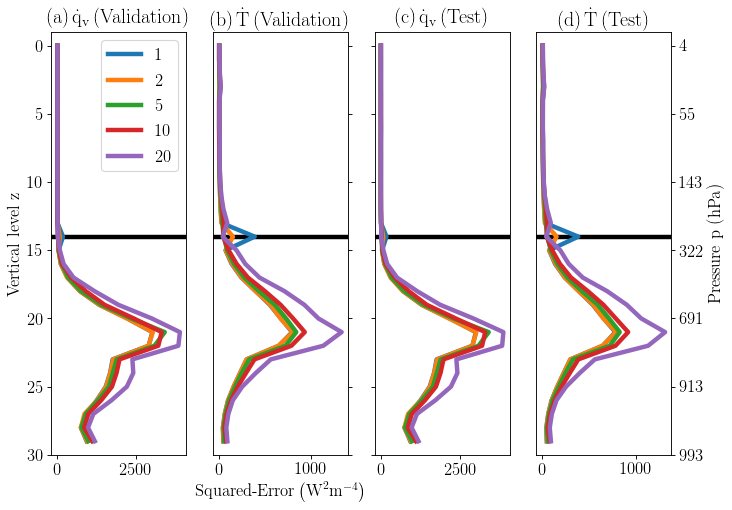

In [40]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):

        ax.plot(np.mean(S[datas]['SE'][multiplier][:,:30],axis=0),
                np.linspace(0,29,num=30),
                label=multiplier)
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):
        ax.plot(np.mean(S[datas]['SE'][multiplier][:,90:120],axis=0),
                np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)

#Save figure
plt.savefig('Fig_prof_wloss.pdf',format='pdf')

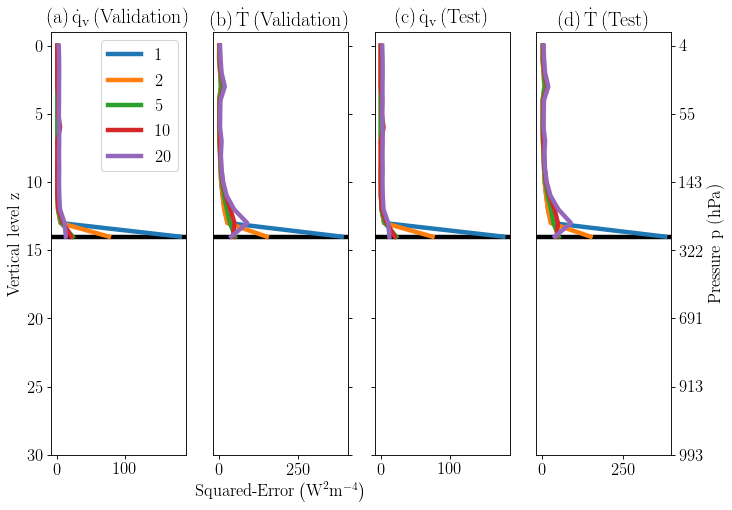

In [37]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):

        ax.plot(np.mean(S[datas]['SE'][multiplier][:,:15],axis=0),
                np.linspace(0,14,num=15),
                label=multiplier)
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for im,multiplier in enumerate(mult_array):
        ax.plot(np.mean(S[datas]['SE'][multiplier][:,90:105],axis=0),
                np.linspace(0,14,num=15))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)

In [66]:
for j,datas in enumerate(DATASET):
    for im,multiplier in enumerate(mult_array):
        print(datas,multiplier,'MSE',np.mean(S[datas]['MSE'][multiplier]),
             'Constraints Penalty',np.mean(S[datas]['TRES'][multiplier]))

valid 1 MSE 158.6894 Constraints Penalty 8.31869e-10
valid 2 MSE 159.09941 Constraints Penalty 6.568054
valid 5 MSE 165.39026 Constraints Penalty 17.24439
valid 10 MSE 186.68095 Constraints Penalty 20.348072
valid 20 MSE 234.10017 Constraints Penalty 22.69987


KeyError: 'test'

## Non-linearly constrained network

See notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/041_ACnet_Non_Linear.ipynb]

In [45]:
path_HDF5 = '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/'
NNarray = ['035_UCnet.hdf5','UCnetNL_10.hdf5','ACnetNL_10.hdf5',
          'UCnet_11.hdf5','UCnetNL_11.hdf5','ACnetNL_11.hdf5',
          'UCnet_12.hdf5','UCnetNL_12.hdf5','ACnetNL_12.hdf5']
NNname = ['$\mathrm{UCnet}$','$\mathrm{UCnet_{NL}}$','$\mathrm{ACnet_{NL}}$'] # TODO: Add UCnet_NL
col = ['k','r','b']

In [46]:
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [43]:
S = {}

hf = open(pathPKL+'2020_03_04_validgen041.pkl','rb')
S['valid'] = pickle.load(hf)
hf.close()

hf = open(pathPKL+'2020_03_04_testgen041.pkl','rb')
S['test'] = pickle.load(hf)
hf.close()

In [50]:
S

{'valid': {'TRES': {'035_UCnet.hdf5': array([3.70572698e+01, 7.15497815e+01, 2.14499573e+02, ...,
          3.03463748e+05, 4.12788805e+04, 2.41339554e+04]),
   'UCnet_11.hdf5': array([5.11612304e+01, 2.87638463e+00, 3.68434522e+00, ...,
          5.12878422e+03, 8.75435971e+02, 1.04184604e+03]),
   'UCnet_12.hdf5': array([   7.63588247,    7.16644555,    7.9671789 , ..., 6111.14151047,
            70.69924711,   42.36114099]),
   'UCnetNL_10.hdf5': array([2.09347648e+00, 5.50917223e+00, 7.77588387e+01, ...,
          8.25768354e+02, 2.15214856e+03, 9.09066051e+02]),
   'UCnetNL_11.hdf5': array([  92.03875365,  123.80490252,  304.22175674, ..., 2064.8739065 ,
           660.18625564,  421.76818583]),
   'UCnetNL_12.hdf5': array([ 165.08067713,  210.97424791,   85.06213634, ...,  582.33380667,
          1125.55120731,  273.08944082]),
   'ACnetNL_10.hdf5': array([8.30408477e-05, 3.76923100e-05, 2.38243508e-06, ...,
          5.56444311e-05, 4.23982452e-05, 5.01082371e-05]),
   'ACnetNL_

In [55]:
S[datas]

{'TRES': {'035_UCnet.hdf5': array([ 97.35956594,  39.83735906,  25.11930071, ..., 227.46628187,
         971.41198694, 279.27160247]),
  'UCnetNL_10.hdf5': array([  4.39717817,   8.35057856,   8.30884863, ..., 804.53598059,
         811.94333019, 743.89651743]),
  'ACnetNL_10.hdf5': array([2.02681693e-06, 3.81068599e-06, 1.39232029e-07, ...,
         7.54021587e-04, 2.48574439e-03, 3.69936100e-03])},
 'MSE': {'035_UCnet.hdf5': array([ 7.45327661,  4.37537089,  6.46957187, ..., 32.88802323,
         52.94135191, 19.19459625]),
  'UCnetNL_10.hdf5': array([ 10.12405781,   6.01361139,   5.1995084 , ..., 108.53307278,
         117.33120668,  65.06872237]),
  'ACnetNL_10.hdf5': array([ 16.46613375,   9.2273996 ,  11.66615598, ..., 111.63939964,
         109.62259105,  88.62363985])},
 'SE': {'035_UCnet.hdf5': array([[1.06655784e-01, 2.58578916e-01, 8.86434373e+00, ...,
          1.94080803e+03, 7.11408045e+01, 4.12713839e+02],
         [1.24178477e-01, 3.70135997e-01, 1.04566493e+01, ...,
  

KeyError: 'UCnet_11.hdf5'

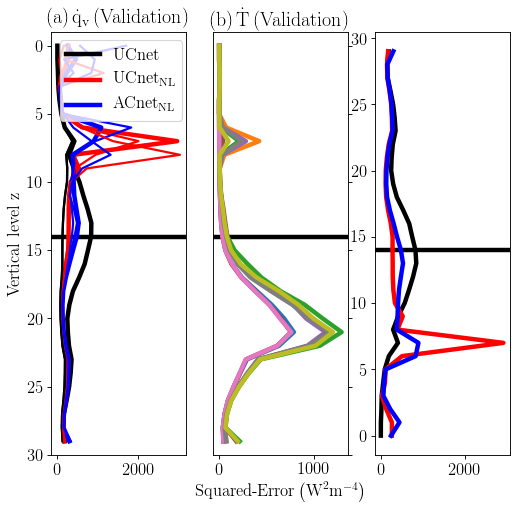

In [52]:
f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

ifig = 0
for j,datas in enumerate(DATASET):

    ### Subplot 1 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        print('i=',i,'nn=',nn,'            ',end='\r')
        if i<3:
            ax.plot(np.mean(S[datas]['SE'][nn][:,:30],axis=0),
                np.linspace(0,29,num=30),
                label=NNname[i],color=col[i])
        else:
            ax.plot(np.mean(S[datas]['SE'][nn][:,:30],axis=0),
                np.linspace(0,29,num=30),color=col[i%3],linewidth=lw/2)
            
        
    if ifig==1: 
        plt.legend()
        plt.ylabel('Vertical level z')
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.title(TITLE[ifig-1])
    
    if ifig==3:
        plt.draw()
        # Change y labels to none
        labels = [item.get_text() for item in ax.get_yticklabels()]
        for ilab,lab in enumerate(labels):
            labels[ilab]=''
        ax.set_yticklabels(labels)

    ### Subplot 2 ###
    ifig += 1
    ax = f.add_subplot(1,4,ifig)

    plt.axhline(y=14,color='k',linewidth=lw,zorder=0)
    for i,nn in enumerate(NNarray):
        ax.plot(np.mean(S[datas]['SE'][nn][:,90:120],axis=0),
                np.linspace(0,29,num=30))
    plt.ylim((YMIN,YMAX))
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    if ifig==2:
        plt.xlabel('$\\textnormal{Squared-Error}\\left(\\textnormal{W}^{2}\\textnormal{m}^{-4}\\right)$')
    elif ifig==4:
        plt.ylabel('$\\textnormal{Pressure\\ p\\ \\ensuremath{\\left(\\textnormal{hPa}\\right)}}$')
    plt.title(TITLE[ifig-1])

    plt.draw()
    # Change y labels to none
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for ilab,lab in enumerate(labels):
        if ifig==2: labels[ilab]=''
        elif ifig==4: 
            IND = min(29,max(0,int(float(labels[ilab][1:-1]))))
            labels[ilab]=str('%01.0f'%coor.lev[IND].values)
    ax.set_yticklabels(labels)

In [72]:
for j,datas in enumerate(DATASET):
    for i,nn in enumerate(NNarray):
        print(datas,nn,'MSE',np.mean(S[datas]['MSE'][nn]),
             'Constraints Penalty',np.mean(S[datas]['TRES'][nn]))

valid 035_UCnet.hdf5 MSE 113.553785925987 Constraints Penalty 212366.71357283558
valid UCnetNL_10.hdf5 MSE 151.52250592805527 Constraints Penalty 3534.8022397378827
valid ACnetNL_10.hdf5 MSE 158.3656055163711 Constraints Penalty 0.0002111572260844254
test 035_UCnet.hdf5 MSE 113.71021776968766 Constraints Penalty 204024.85325491018
test UCnetNL_10.hdf5 MSE 151.2431999117424 Constraints Penalty 3492.563697030215
test ACnetNL_10.hdf5 MSE 157.3546145796691 Constraints Penalty 0.0002087446187475865
